In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import keras
from tensorflow.keras.models import Sequential, Model

## Loading dataset

In [2]:
parasitized_cell_path= r"C:\Users\sanik\OneDrive\ML\Deep Learning project\cell_images\Parasitized"
uninfected_cell_path= r"C:\Users\sanik\OneDrive\ML\Deep Learning project\cell_images\Uninfected"
cell_data = r"C:\Users\sanik\OneDrive\ML\Deep Learning project\cell_images"

In [3]:
print(os.listdir(cell_data))

['Parasitized', 'Uninfected']


In [4]:
parasitized_dir = os.listdir(parasitized_cell_path)
uninfected_dir = os.listdir(uninfected_cell_path)

print("Number of uninfected cells", len(uninfected_dir))
print("Number of parasitized cells", len(parasitized_dir))

Number of uninfected cells 13780
Number of parasitized cells 13776


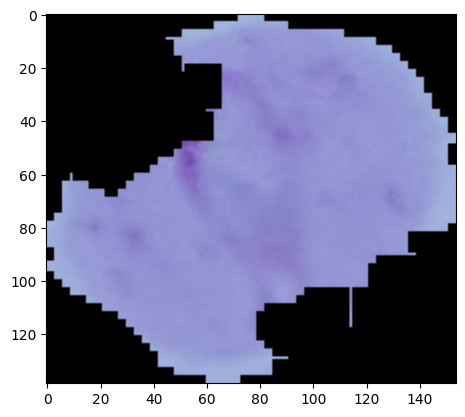

In [5]:
#sample image of parasitized cell
import cv2

img_path = os.path.join(parasitized_cell_path, parasitized_dir[102])
img1= cv2.imread(img_path)
plt.imshow(img1)

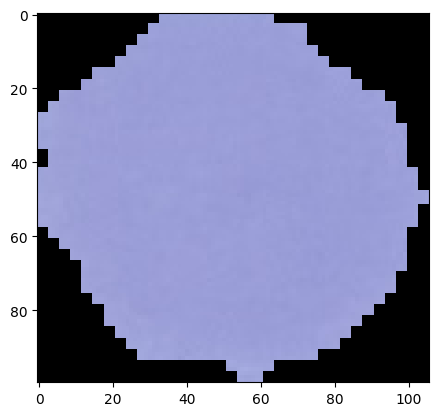

In [6]:
#sample image of uninfected cell
import cv2

img_path = os.path.join(uninfected_cell_path, uninfected_dir[100])
img1= cv2.imread(img_path)
plt.imshow(img1)

## Preprocessing

Resizing the image

In [7]:
# # Target size for resizing images
# target_size = (180, 180)  

# # Iterate through the images in the dataset directory
# for filename in os.listdir(parasitized_cell_path):
#     if filename.endswith(".jpg") or filename.endswith(".png"):  
#         filepath = os.path.join(parasitized_cell_path, filename)
#         # Read the image using OpenCV
#         img = cv2.imread(filepath)
#         # Resize the image
#         resized_img = cv2.resize(img, target_size, interpolation=cv2.INTER_AREA)  
#         # Save the resized image, overwrite the original if needed
#         cv2.imwrite(filepath, resized_img)

# print("Images resized successfully.")

In [8]:
# # Target size for resizing images
# target_size = (180, 180)  

# # Iterate through the images in the dataset directory
# for filename in os.listdir(uninfected_cell_path):
#     if filename.endswith(".jpg") or filename.endswith(".png"):  
#         filepath = os.path.join(uninfected_cell_path, filename)
#         # Read the image using OpenCV
#         img = cv2.imread(filepath)
#         # Resize the image
#         resized_img = cv2.resize(img, target_size, interpolation=cv2.INTER_AREA)  
#         # Save the resized image, overwrite the original if needed
#         cv2.imwrite(filepath, resized_img)

# print("Images resized successfully.")

In [9]:
output_folder="/kaggle/working/Data_split"

train_folder = os.path.join(output_folder, 'train')
test_folder = os.path.join(output_folder, 'test')
os.makedirs(train_folder, exist_ok=True)
os.makedirs(test_folder, exist_ok=True)

In [10]:
# Define the classes (parasitized and uninfected)
classes = ['Parasitized', 'Uninfected']

In [9]:
# # Iterate over the classes and split the data
from sklearn.model_selection import train_test_split
import shutil

for class_name in classes:
    class_folder = os.path.join(cell_data, class_name)
    
    # List all the images in the class folder
    images = os.listdir(class_folder)
    
    # Split the images into train and test sets
    train_images, test_images = train_test_split(images, test_size=0.2, random_state=42)
    
    # Create class-specific folders in train and test
    train_class_folder = os.path.join(train_folder, class_name)
    test_class_folder = os.path.join(test_folder, class_name)
    os.makedirs(train_class_folder, exist_ok=True)
    os.makedirs(test_class_folder, exist_ok=True)
    
    # Move images to the respective folders
    for image in train_images:
        src_path = os.path.join(class_folder, image)
        dest_path = os.path.join(train_class_folder, image)
        shutil.copy(src_path, dest_path)
    
    for image in test_images:
        src_path = os.path.join(class_folder, image)
        dest_path = os.path.join(test_class_folder, image)
        shutil.copy(src_path, dest_path)

print("Dataset split and organized into train and test folders.")

Dataset split and organized into train and test folders.


In [11]:
train_path='Data_split/train' 
test_path='Data_split/test'

In [12]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,MaxPool2D,Dropout,Flatten,BatchNormalization,MaxPooling2D,Activation
from tensorflow.keras.optimizers import RMSprop,Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.image as mpimg
from tensorflow.keras import layers 
from tensorflow.keras import Model
from sklearn.metrics import classification_report,confusion_matrix

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_shape = (150, 150, 3)
image_gen = ImageDataGenerator(rotation_range=20,
                              width_shift_range=0.1,
                              height_shift_range=0.1,
                              rescale=1/225,
                              shear_range=0.1,
                              zoom_range=0.1,
                              horizontal_flip=True,
                              fill_mode='nearest',
                              validation_split=0.5)

In [14]:
train = image_gen.flow_from_directory(train_path,
                                     target_size = img_shape[:2],
                                     color_mode = 'rgb',
                                     batch_size = 32,
                                     class_mode = 'binary',
                                     subset = 'training',
                                     shuffle = True)

validation = image_gen.flow_from_directory(test_path,
                                     target_size = img_shape[:2],
                                     color_mode ='rgb',
                                     batch_size = 32,
                                     class_mode = 'binary',
                                     subset = 'validation',
                                     shuffle = False)

Found 11022 images belonging to 2 classes.
Found 2755 images belonging to 2 classes.


### VGG16 model

In [15]:
from tensorflow.keras.applications.vgg16 import VGG16
base_model = VGG16(input_shape = (150, 150, 3), # Shape of our images
include_top = False, # Leave out the last fully connected layer
weights = 'imagenet')

In [16]:
for layer in base_model.layers:
    layer.trainable = False
#Flatten the output layer to 1 dimension
x = layers.Flatten()(base_model.output)

# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)

# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)

# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.models.Model(base_model.input, x)

model.compile(optimizer = 'adam' , loss = 'binary_crossentropy',metrics = ['acc'])

In [17]:
vggmodel = model.fit(train, validation_data = validation,batch_size = 32,epochs = 20)

Epoch 1/20
345/345 [==============================] - 590s 2s/step - loss: 0.4102 - acc: 0.8345 - val_loss: 0.2926 - val_acc: 0.8766
Epoch 2/20
345/345 [==============================] - 565s 2s/step - loss: 0.2721 - acc: 0.8888 - val_loss: 0.2908 - val_acc: 0.8831
Epoch 3/20
345/345 [==============================] - 568s 2s/step - loss: 0.2503 - acc: 0.9003 - val_loss: 0.2644 - val_acc: 0.8889
Epoch 4/20
345/345 [==============================] - 578s 2s/step - loss: 0.2530 - acc: 0.9003 - val_loss: 0.2514 - val_acc: 0.8918
Epoch 5/20
345/345 [==============================] - 570s 2s/step - loss: 0.2455 - acc: 0.9042 - val_loss: 0.2590 - val_acc: 0.8915
Epoch 6/20
345/345 [==============================] - 567s 2s/step - loss: 0.2479 - acc: 0.9056 - val_loss: 0.2480 - val_acc: 0.8998
Epoch 7/20
345/345 [==============================] - 495s 1s/step - loss: 0.2354 - acc: 0.9075 - val_loss: 0.2791 - val_acc: 0.8915
Epoch 8/20
345/345 [==============================] - 501s 1s/step - 

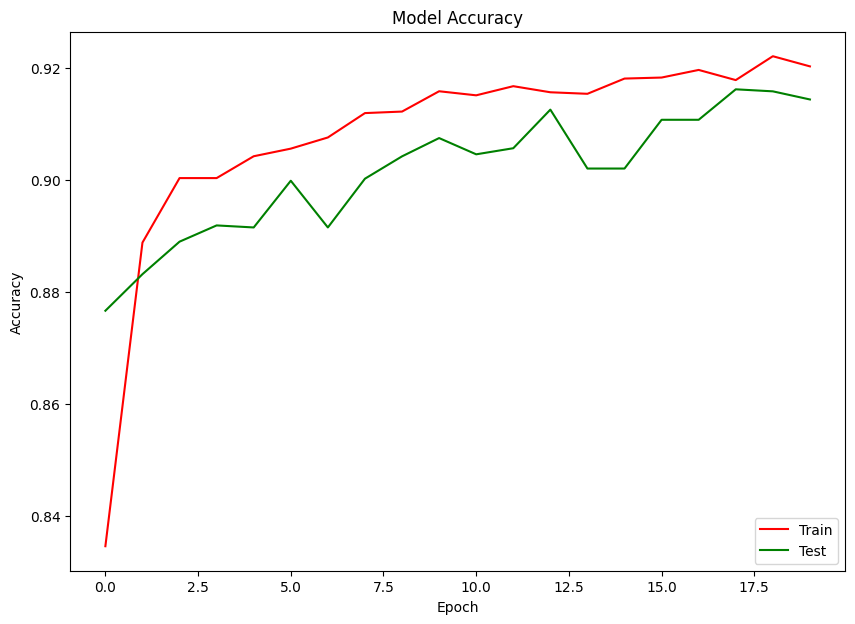

In [18]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)
ax.set_facecolor('w')
ax.plot(vggmodel.history['acc'], color='red')  # Use 'accuracy' instead of 'acc'
ax.plot(vggmodel.history['val_acc'], color='green')  # Use 'val_accuracy' instead of 'val_acc'
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()


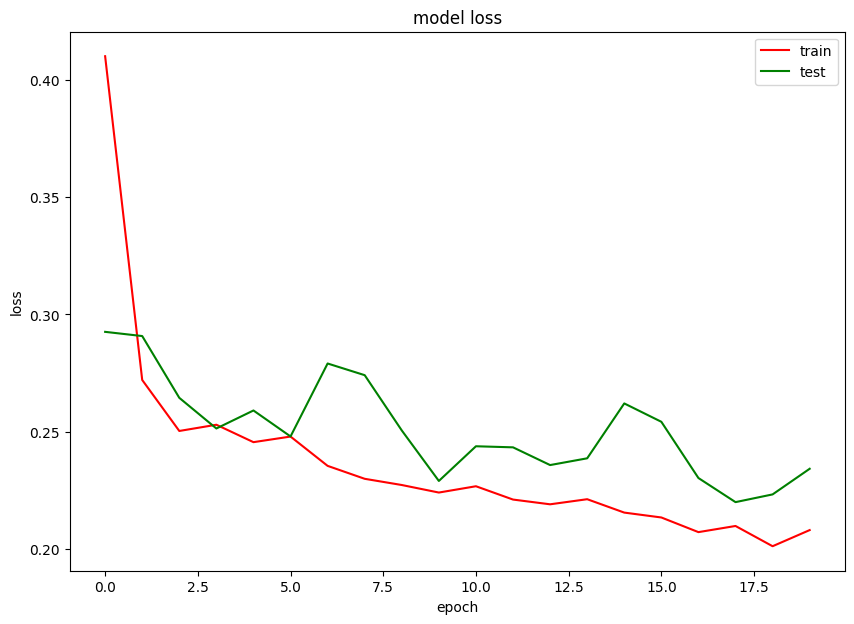

In [19]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)
ax.set_facecolor('w')
ax.plot(vggmodel.history['loss'], color='red')
ax.plot(vggmodel.history['val_loss'], color ='green')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [21]:
import os
from tensorflow.keras.models import Sequential

# Specify the directory where you want to save the model
save_directory = "C:/Users/sanik/OneDrive/ML/Deep Learning project/"

# Create the directory if it doesn't exist
os.makedirs(save_directory, exist_ok=True)

# Specify the filename for your model
model_filename = "vgg16_model.h5"

# Combine the directory and filename
full_path = os.path.join(save_directory, model_filename)

# Save the model
model.save(full_path)

print(f"Model saved to {full_path}")

Model saved to C:/Users/sanik/OneDrive/ML/Deep Learning project/vgg16_model.h5


In [30]:
import os
from tensorflow.keras.models import load_model

load_directory = "C:/Users/sanik/OneDrive/ML/Deep Learning project/"
model_filename = "vgg16_model.h5"

full_path = os.path.join(load_directory, model_filename)

# Check if the file exists
if os.path.exists(full_path):
    # Load the model
    vggmodel = load_model(full_path)
    print(f"Model loaded from {full_path}")
else:
    print(f"Model file not found at {full_path}")

Model loaded from /kaggle/working/vgg16_model.h5


## CNN model

In [28]:
cnn_model = tf.keras.models.Sequential([
    #first_convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    #second_convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    #third_convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    #fourth_convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid') 
])

In [29]:
cnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 74, 74, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 17, 17, 128)      

In [30]:
from keras.losses import binary_crossentropy

cnn_model.compile(loss=binary_crossentropy,
              optimizer = 'adam',
              metrics=['accuracy'])

In [32]:
cnn_model=cnn_model.fit(train,validation_data=validation,steps_per_epoch=200,batch_size = 32, epochs=20)

Epoch 1/20
200/200 [==============================] - 134s 667ms/step - loss: 0.1628 - accuracy: 0.9495 - val_loss: 0.1756 - val_accuracy: 0.9514
Epoch 2/20
200/200 [==============================] - 124s 622ms/step - loss: 0.1672 - accuracy: 0.9464 - val_loss: 0.1760 - val_accuracy: 0.9488
Epoch 3/20
200/200 [==============================] - 125s 624ms/step - loss: 0.1689 - accuracy: 0.9470 - val_loss: 0.1793 - val_accuracy: 0.9452
Epoch 4/20
200/200 [==============================] - 126s 632ms/step - loss: 0.1629 - accuracy: 0.9469 - val_loss: 0.1778 - val_accuracy: 0.9506
Epoch 5/20
200/200 [==============================] - 122s 609ms/step - loss: 0.1580 - accuracy: 0.9483 - val_loss: 0.1823 - val_accuracy: 0.9456
Epoch 6/20
200/200 [==============================] - 123s 617ms/step - loss: 0.1607 - accuracy: 0.9464 - val_loss: 0.1604 - val_accuracy: 0.9557
Epoch 7/20
200/200 [==============================] - 118s 589ms/step - loss: 0.1510 - accuracy: 0.9549 - val_loss: 0.1851 -

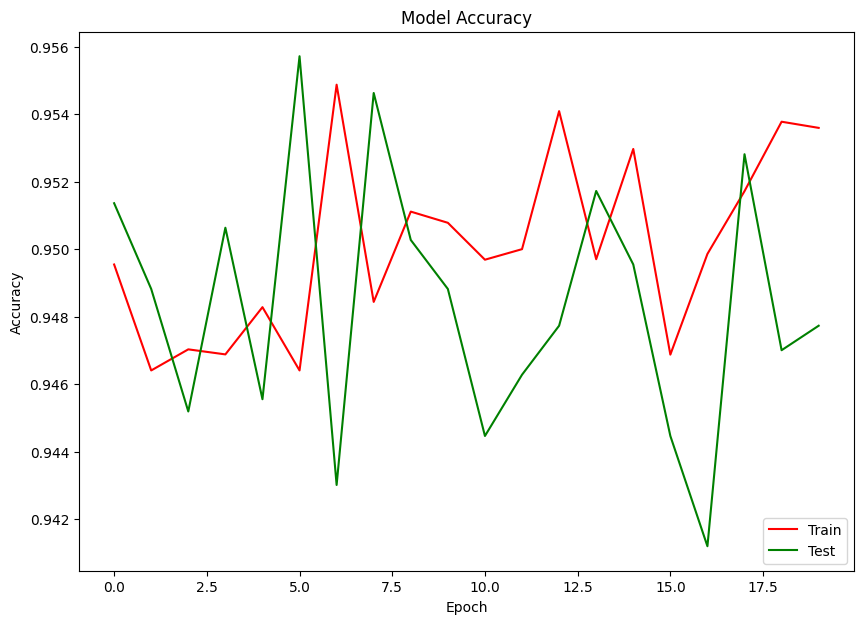

In [33]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)
ax.set_facecolor('w')
ax.plot(cnn_model.history['accuracy'], color='red')  # Use 'accuracy' instead of 'acc'
ax.plot(cnn_model.history['val_accuracy'], color='green')  # Use 'val_accuracy' instead of 'val_acc'
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()


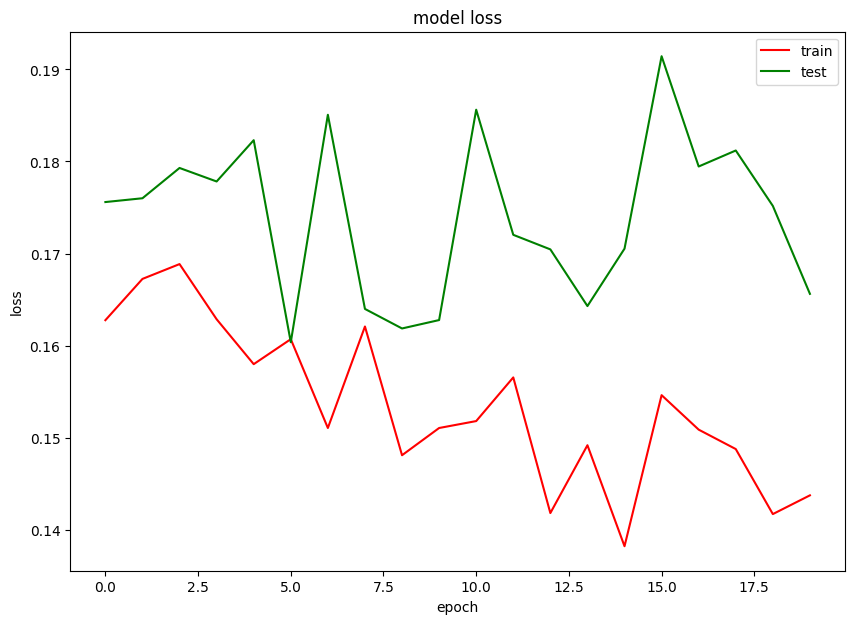

In [34]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)
ax.set_facecolor('w')
ax.plot(cnn_model.history['loss'], color='red')
ax.plot(cnn_model.history['val_loss'], color ='green')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [35]:
import os
from tensorflow.keras.models import Sequential

save_directory = "C:/Users/sanik/OneDrive/ML/Deep Learning project/"
os.makedirs(save_directory, exist_ok=True)
model_filename = "cnn_model.h5"

full_path = os.path.join(save_directory, model_filename)

model.save(full_path)

print(f"Model saved to {full_path}")

Model saved to C:/Users/sanik/OneDrive/ML/Deep Learning project/cnn_model.h5


## ResNet-50

In [46]:
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from keras.models import load_model
from keras.preprocessing import image
from keras.applications.resnet50 import ResNet50
model = ResNet50(weights='imagenet')

In [47]:
train_datagen = ImageDataGenerator(zoom_range=0.15,width_shift_range=0.2,height_shift_range=0.2,shear_range=0.15)
test_datagen = ImageDataGenerator()

In [51]:
train_generator = train_datagen.flow_from_directory(train_path,
                                                    target_size=(224, 224),
                                                    batch_size=32,
                                                    shuffle=True,
                                                    class_mode='binary')

test_generator = test_datagen.flow_from_directory(test_path,
                                                  target_size=(224, 224),
                                                  batch_size=32,
                                                  shuffle=False,
                                                  class_mode='binary')

Found 22043 images belonging to 2 classes.
Found 5511 images belonging to 2 classes.


In [52]:
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.optimizers import SGD

base_model = ResNet50(input_shape=(224, 224, 3))
headModel = base_model.output
headModel = Flatten()(headModel)
headModel=Dense(256, activation='relu', name='fc1',kernel_initializer=glorot_uniform(seed=0))(headModel)
headModel=Dense(128, activation='relu', name='fc2',kernel_initializer=glorot_uniform(seed=0))(headModel)
headModel = Dense( 1,activation='sigmoid', name='fc3',kernel_initializer=glorot_uniform(seed=0))(headModel)
resnetmodel = Model(inputs=base_model.input, outputs=headModel)
resnetmodel.summary()


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_6[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

In [53]:
for layer in base_model.layers:
    layer.trainable = False

In [54]:
opt = SGD(learning_rate=1e-3, momentum=0.9)
# Compile the model
resnetmodel.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])


In [55]:
es=EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=20)

In [56]:
# Train the model using the fit method
H = resnetmodel.fit(train_generator,validation_data=test_generator,
                    steps_per_epoch=200,epochs=15,verbose=1,
                    callbacks=[es])

Epoch 1/15
200/200 [==============================] - 632s 3s/step - loss: 0.6902 - accuracy: 0.6345 - val_loss: 0.6882 - val_accuracy: 0.6267
Epoch 2/15
200/200 [==============================] - 610s 3s/step - loss: 0.6865 - accuracy: 0.6587 - val_loss: 0.6847 - val_accuracy: 0.6384
Epoch 3/15
200/200 [==============================] - 611s 3s/step - loss: 0.6827 - accuracy: 0.6721 - val_loss: 0.6811 - val_accuracy: 0.6344
Epoch 4/15
200/200 [==============================] - 609s 3s/step - loss: 0.6786 - accuracy: 0.6749 - val_loss: 0.6773 - val_accuracy: 0.6451
Epoch 5/15
200/200 [==============================] - 607s 3s/step - loss: 0.6752 - accuracy: 0.6690 - val_loss: 0.6734 - val_accuracy: 0.6600
Epoch 6/15
200/200 [==============================] - 974s 5s/step - loss: 0.6712 - accuracy: 0.6870 - val_loss: 0.6689 - val_accuracy: 0.6670
Epoch 7/15
200/200 [==============================] - 618s 3s/step - loss: 0.6678 - accuracy: 0.6870 - val_loss: 0.6646 - val_accuracy: 0.6668

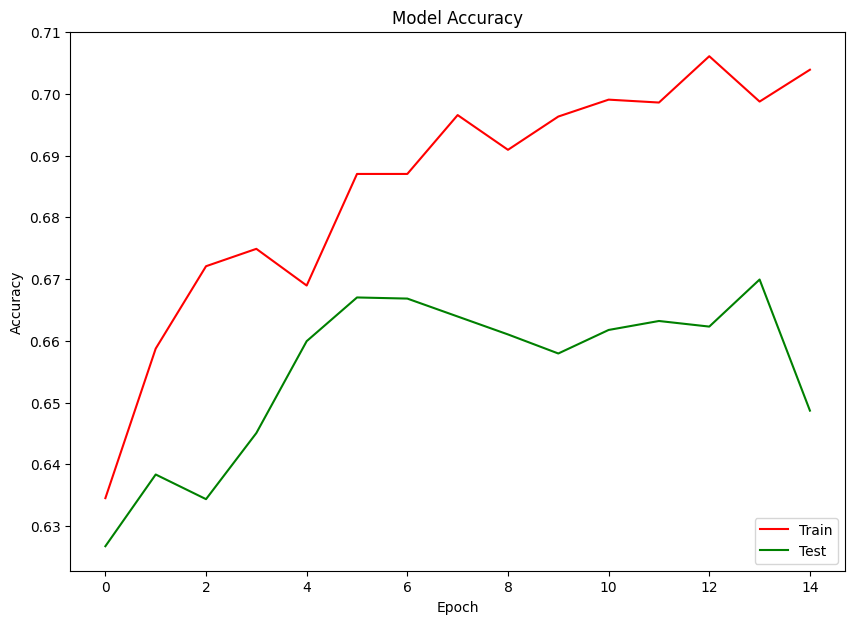

In [57]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)
ax.set_facecolor('w')
ax.plot(H.history['accuracy'], color='red')  # Use 'accuracy' instead of 'acc'
ax.plot(H.history['val_accuracy'], color='green')  # Use 'val_accuracy' instead of 'val_acc'
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()


In [58]:
import os
from tensorflow.keras.models import Sequential

save_directory = "C:/Users/sanik/OneDrive/ML/Deep Learning project/"
os.makedirs(save_directory, exist_ok=True)
model_filename = "resnet_model.h5"

full_path = os.path.join(save_directory, model_filename)

model.save(full_path)

print(f"Model saved to {full_path}")

Model saved to C:/Users/sanik/OneDrive/ML/Deep Learning project/resnet_model.h5
